# 初始化

操作ElasticSearch的包通常有较为底层的py-elasticsearch和高层的py-elasticsearch-dsl。在以下的例子中，我们仅仅用到较为低层的elasticsearch包。因为相对于更高层的elasticsearch-dsl，搜索的请求需要自己拼凑，在出现问题时能够更方便找到出错的原因。另外Kibana也提供了Dev Tools工具，可以在这里进行实验，将实验好的请求直接用来请求elasticsearch即可。

In [49]:
from datetime import datetime
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('figure', figsize=(10, 5))
pd.options.display.max_rows = 20

def format(value):
    return '{:0,.2f}'.format(value)


es = Elasticsearch()

BEGIN_DATE = '2000-01-01'
END_DATE = '2017-01-01'

# 项目和用户增长情况

计算项目和用户数量非常简单，ElasticSearch提供的match_all搜索可以快速返回有多少项目数量。通过读取返回值中的hits.total字段即可。

从采集到的数据来看，则项目数量在740万左右，用户数量在1700万，两者相差大约56%和35%左右。项目数和用户数总体上都存在一些差异，差异可能来自于不同的统计方式。Freelaner的用户规模和项目规模在加速增长中，预计在2018年初突破2000万用户和800万项目。

In [50]:
# 计算所有的项目数量
res = es.search(index="project", body={"query": {"match_all": {}}})
format(res['hits']['total'])

'7,405,296.00'

In [51]:
# 计算所有用户数量
res = es.search(index="user", body={"query": {"match_all": {}}})
format(res['hits']['total'])

'17,329,285.00'

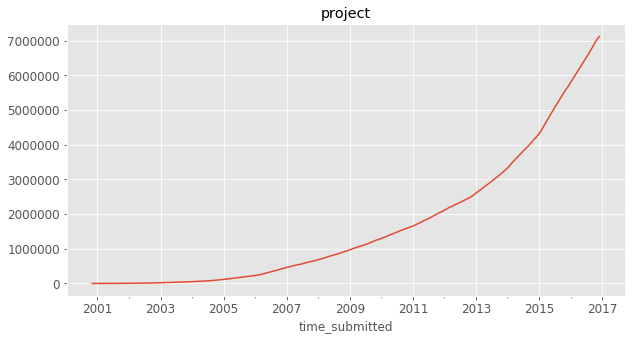

In [52]:
# 项目数量增长情况


def get_trend(index, field):
    query = {"size": 0,
             "aggs": {
                 index: {
                     "date_histogram": {
                         "field": field,
                         "interval": "month",
                         "format": "yyyy-MM-dd"
                     }
                 }
             }
             }

    res = es.search(index=index, body=query)
    df = pd.DataFrame.from_dict(res['aggregations'][index]['buckets'])

    # 返回值中会得到按月对应的总数值，其中月份值放在key_as_string中，我们将这一项提取出来
    df['time_submitted'] = pd.to_datetime(df['key_as_string'])
    df = df.drop(['key', 'key_as_string'], 1)
    df.set_index('time_submitted', inplace=True)
    df.columns = ['count']
    df[index + '_cumsum'] = df.cumsum()

    # 筛选时间段
    df = df[(df.index > BEGIN_DATE) & (df.index < END_DATE)]
    return df


df = get_trend("project", "project.time_submitted")
df.plot(y='project_cumsum', title="project", legend=False)
plt.show()
project_df = df['project_cumsum']

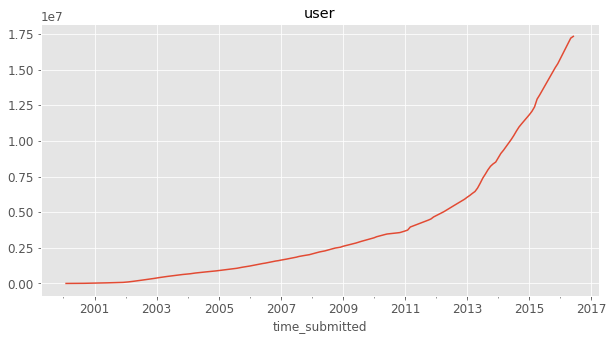

In [53]:
# 用户数量增长
df = get_trend("user", "user.registration_date")
user_df = df['user_cumsum']
df.plot(y='user_cumsum', title="user", legend=False)
plt.show()
user_df = df['user_cumsum']

# 会员分布
ElasticSearch的聚合方法可以根据提供的字段（field）进行计算。以下请求中根据`user.membership_package.name.keyword`出现的次数进行计算。

在Freelancer的会员体系中，免费的会员有1727万名，占据了99.66%（图中无标示）。付费会员总共有5.8万，免费和付费会员比为295:1。
注：其中有一些会员类型可能是Freelancer之前的老会员类型。

In [54]:
# 会员分布

query = {
    "size": 0,
    "aggs": {
        "membership": {
            "terms": {
                "field": "user.membership_package.name.keyword",
                "size": 20
            }
        }
    }
}

res = es.search(index="user", body=query)

# 将返回值转换成DataFrame
df = pd.DataFrame.from_dict(res['aggregations']['membership']['buckets'])
df.set_index("key")
df.columns = ['value', 'name']
df[1:9].to_json("./web/data/member.json", orient='records')
df = df.set_index('name')
df

,value
name,
free,17270758
intro,20891
plus,18228
professional,9799
basic,5064
starter,3305
standard,612
premier,518
premium,109


DataFrame的sum()方法可以很方便的计算总和。

In [55]:
# 付费会员总量
df['value'][1:].sum()

58527

In [56]:
# 免费会员：付费会员
df['value'][0].sum() / df['value'][1:].sum()

295.09043689237444

In [57]:
# 1000个会员中，有多少个免费用户
df['value'][0].sum() / df['value'].sum() * 1000

996.6226535024382

为了计算每月会员收入，我们将网站对会员的收费标准加入到上述DataFrame中。然后将DataFrame的value字段和fee字段相乘，得到收入的总和。注意有几个字段由于找不到对应的费用（猜测是以前的会员类型），所以没有赋值。从数值上来看，professional会员类型具有最多的收入。

In [58]:
# 计算每月会员收入
df.loc['intro', 'fee'] = 0.99
df.loc['free', 'fee'] = 0
df.loc['basic', 'fee'] = 4.95
df.loc['plus', 'fee'] = 9.95
df.loc['professional', 'fee'] = 29.95
df.loc['premier', 'fee'] = 59.95
income = df['value'] * df['fee']
income.to_json("./web/data/member-income.json")
income

name
free                 0.00
intro            20682.09
plus            181368.60
professional    293480.05
basic            25066.80
starter               NaN
standard              NaN
premier          31054.10
premium               NaN
corporate             NaN
dtype: float64

In [59]:
# 合并用户和项目的表，以便后续使用

project_user_df = pd.concat([user_df, project_df], axis=1)
project_user_df = project_user_df[(
    project_user_df.index > BEGIN_DATE) & (project_user_df.index < END_DATE)]
project_user_df.to_json("./web/data/project-user.json")

# 自由职业者全球分布

针对用户所在的国家进行聚合，可以得到国家对应的注册用户的分布。以下使用aggs操作对field按照terms的数量进行聚合。

在结果中显示，全球分布中，以美国和印度为第一梯队，菲律宾、印度尼西亚、巴基斯坦紧为第二梯队，英国、澳大利亚、孟加拉国紧跟其后，巴西等国家也有较大的比重。

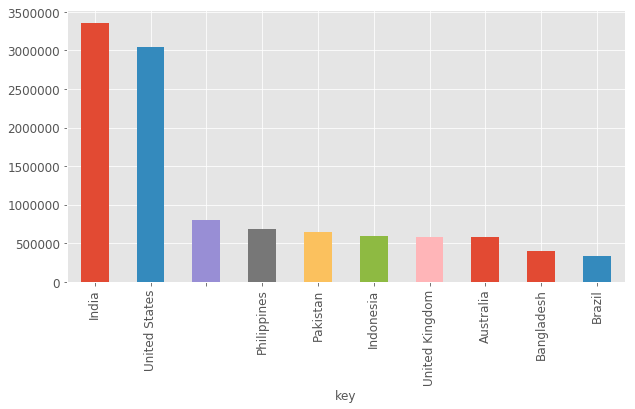

In [60]:
# 注册用户分布


def get_distrubution(index, field, size):
    query = {
        "size": 0,
        "aggs": {
            "agg_result": {
                "terms": {
                    "field": field,
                    "size": size
                }
            }
        }
    }

    res = es.search(index=index, body=query)
    df = pd.DataFrame.from_dict(res['aggregations']['agg_result']['buckets'])
    df.set_index('key', inplace=True)

    return df

df = get_distrubution("user", "user.location.country.name.keyword", 200)
# 取Top-10进行展示
df[0:10].plot.bar(y='doc_count', legend=False)
plt.show()
df.to_json("./web/data/user-country.json")

# 项目所有者全球分布

和自由职业者分布类似，美国和印度的项目占领了很大的份额。英国、澳大利亚、加拿大等发达国家保持着稳定的市场。菲律宾、巴基斯坦跟随其后，这些项目很有可能是二次外包的项目。

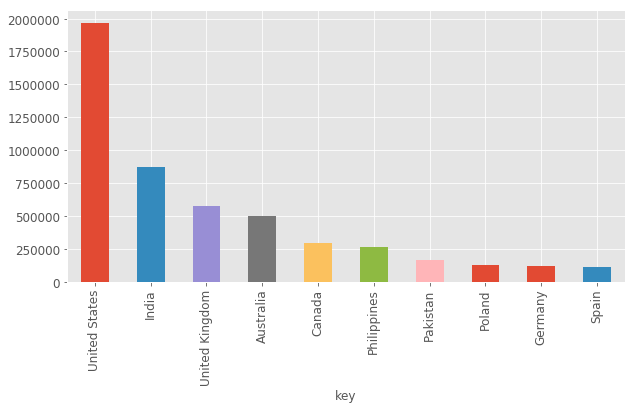

In [61]:
# 项目所有者分布

df = get_distrubution(
    "project", "project.owner.location.country.name.keyword", 200)
df[0:10].plot.bar(y='doc_count', legend=False)
plt.show()
df.to_json("./web/data/owner-country.json")

# 业务种类分布

在业务种类分不中，网站35%的项目都是网站建设和软件相关业务，有23%的项目是设计类的项目，10%的是写作和内容类项目。这三类项目占据了7成以上的份额。

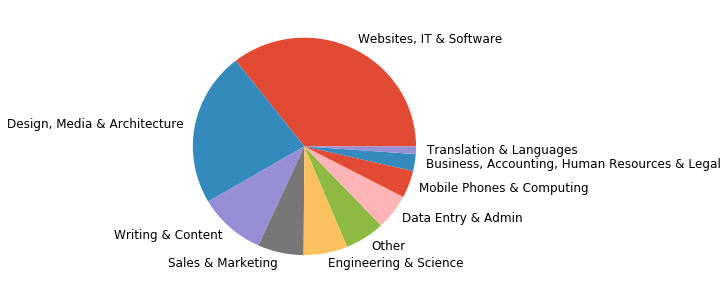

In [62]:
# 类型分布
df = get_distrubution(
    "project", "project.jobs.category.name.keyword", 10)

df.plot.pie(y='doc_count', figsize=(5,5), legend=False, label="")
plt.show()
df.to_json("./web/data/category.json")

# 具体业务分布

在具体的业务分布中，前60%的市场都和网站建设和设计有关。其中PHP占据了20%的市场，这和WordPress等基于PHP的CMS网站建设有很大关系。Graphic Design占据12%的市场，紧接着又是网站建设。其他的类型则市场相对较小。

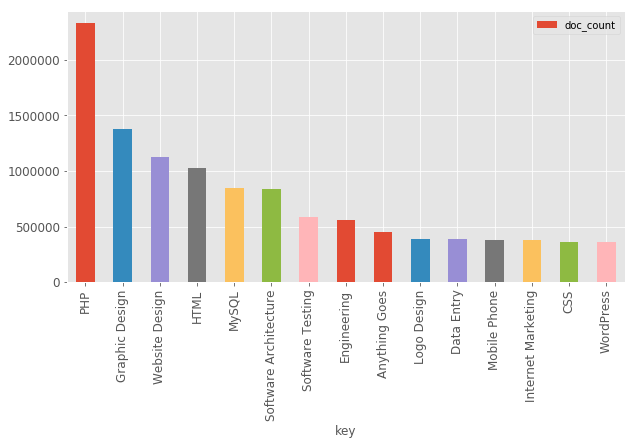

In [63]:
# 类型细分
df = get_distrubution("project", "project.jobs.name.keyword", 15)
df.plot.bar(y='doc_count')
plt.show()
df.to_json("./web/data/category-more.json")

# 全球接单数TOP20

通过`user.reputation.entire_history.all`进行排序可以得到排序最靠前的20个ID。对每个ID进行查询并计算可以得到总共赚了多少钱以及平均值。在结果中显示，全球接单数最多的20名自由职业中，来自于印度、巴基斯坦、菲律宾等欠发达国家的最多。 但接单数多并不意味着赚取的钱最多，接单数最多的平均每单才1美元不到，而最高的也才25美元， 说明在这些国家接的单都是价格低廉的单，总体赚钱不多。

In [64]:
import pandas as pd
from IPython.display import Image, HTML

# 获取整个freelancer中做项目最多的
query_get_most_jobs_count = {
    "size": 20,
    "query": {
        "match_all": {
        }
    },
    "sort": {
        "user.reputation.entire_history.all": "desc"
    }
}


def calc_earned(id):
    query = {
        "query": {
            "match": {
                "_id": id
            }
        }
    }

    res = es.search(index="userreview", body=query)

    sum = 0
    if len(res['hits']['hits']) == 0:
        # 有可能有数据不完整的情况，跳过以0计算
        return 0

    for review in res['hits']['hits'][0]['_source']['userreview']:
        if review['sealed']:
            # 不公开项目，跳过
            continue

        # 转换成以美元计数
        sum += review['paid_amount'] * review['currency']['exchange_rate']

    return sum


res = es.search(index="user", body=query_get_most_jobs_count)

# 为每一项计算赚到的钱
top_list = [(x['_source']['user']['public_name'], x['_source']['user']['location']['country']['name'],
             x['_source']['user']['reputation']['entire_history']['all'],  calc_earned(x['_id']))
            for x in res['hits']['hits']]

top_df = pd.DataFrame(top_list, columns=["user", "country", "count", "earned"])
top_df['average'] = top_df['earned']/top_df['count']
top_df.to_json("./web/data/top-world.json", orient='records')
top_df

,user,country,count,earned,average
0,colorgraphicz,India,5888,5661.123601,0.961468
1,Djdesign,Pakistan,5670,0.000000,0.000000
2,marjanahmed13,Bangladesh,5175,8655.865853,1.672631
3,botFlnETLJ,Philippines,4023,0.000000,0.000000
4,sn66,Pakistan,4007,0.000000,0.000000
5,DezineGeek,Pakistan,3898,0.000000,0.000000
6,crea8ivedesign,Pakistan,3751,7201.721368,1.919947
7,pinky,India,3725,10005.004539,2.685907
8,calciustech,Romania,3515,24158.596851,6.873001
9,AttariBros,Pakistan,3431,5072.631356,1.478470


In [65]:
# 看看他们做的项目的情况

user_list = top_df['user'].tolist()
query = {
    "size": len(user_list),
    "query": {
        "constant_score": {
            "filter": {
                "terms": {
                    "user.public_name.keyword": user_list
                }
            }
        }
    }
}

res = es.search(index="user", body=query)

d = []
for hit in res['hits']['hits']:
    user = hit['_source']['user']
    for job in user['reputation']['job_history']['job_counts']:
        d.append((user['public_name'], job['job']['category']
                  ['name'], job['job']['name'], job['count']))

df = pd.DataFrame(
    d, columns=['username', 'category', 'category_detail_name', 'count'])
df.set_index(['username', 'category', 'category_detail_name'])

count
username      category                     category_detail_name        
Alexod        Websites, IT & Software      PHP                       27
                                           C++ Programming           22
                                           Software Architecture     20
                                           Javascript                11
                                           C Programming             11
marjanahmed13 Sales & Marketing            Facebook Marketing      2775
              Websites, IT & Software      Social Networking       1783
              Sales & Marketing            Internet Marketing      1182
              Websites, IT & Software      Twitter                  779
                                           SEO                      603
...                                                                 ...
pinky         Design, Media & Architecture Graphic Design          2036
                                           Logo Design             1658
                                           Banner Design            642
                                           Adobe Flash              587
                                           Website Design           515
theDesignerz  Design, Media & Architecture Graphic Design          2324
                                           Logo Design             1746
                                           Photoshop                985
                                           Brochure Design          926
                                           Website Design           808

[97 rows x 1 columns]

# 生成桑基图nodes

图标、媒体设计类是最多的单，其中Graphic Design和Logo Design占据了最多的份额。其次是网站建设，在网站建设中PHP依然是很火的，和WordPress等PHP架构的网站息息相关。后续在动态电子书中，会用到这里的输出结果。

In [66]:
# 生成桑基图nodes
nodes = []
nodes = nodes + df['username'].unique().tolist() + df['category'].unique().tolist() + \
    df['category_detail_name'].unique().tolist()
pd.DataFrame(nodes, columns=['name']).to_json(
    "./web/data/top-nodes.json", orient='records')

# 生成links
df_user_to_detail = df.groupby(['username', 'category_detail_name']).sum()
df_user_to_detail.to_json(
    "./web/data/top-user-to-detail.json", orient='split')

display(df_user_to_detail)

df_detail_to_category = df.groupby(['category_detail_name', 'category']).sum()

display(df_detail_to_category)
df_detail_to_category.to_json(
    "./web/data/top-detail-to-category.json", orient='split')

count
username     category_detail_name        
Alexod       C Programming             11
             C++ Programming           22
             Javascript                11
             PHP                       27
             Software Architecture     20
AttariBros   Graphic Design          2550
             Logo Design             1788
             Photoshop                781
             Photoshop Design         526
             Website Design           492
...                                   ...
theDesignerz Brochure Design          926
             Graphic Design          2324
             Logo Design             1746
             Photoshop                985
             Website Design           808
vano101      C Programming            757
             C# Programming           447
             C++ Programming          805
             Java                     584
             Software Architecture    692

[97 rows x 1 columns]

,,count
category_detail_name,category,
Adobe Flash,"Design, Media & Architecture",587
Advertising,Sales & Marketing,367
Article Rewriting,Writing & Content,200
Articles,Writing & Content,1560
Banner Design,"Design, Media & Architecture",2225
Brochure Design,"Design, Media & Architecture",1856
C Programming,"Websites, IT & Software",768
C# Programming,"Websites, IT & Software",447
C++ Programming,"Websites, IT & Software",827


# 中国接单数TOP20

通过在查询中增加一个对`user.location.country.name.keyword`的过滤，可以得到中国的接单数TOP20对应的收入和每单收入。

结果显示，虽然在全世界范围内中国的自由职业者不算太多，但对比全球接单最多的国家（印度、巴基斯坦等）中国的自由职业者平均每单的价格均超过了15美元，这应该和中国的实际消费水平相关。

与全球类似，第一名SunrisePHP为了和其他国家的低价竞争，只能以低价取胜，虽然数量很多但整体收入欠佳。
形成鲜明对比的zhengnami13，平均每单价格高的700美元，与选择的高质量的工程的性质有关。

In [67]:
import pandas as pd
from IPython.display import Image, HTML

# 中国整个freelancer中做项目最多的
query = {
    "size": 20,
    "query": {
        "match": {
            "user.location.country.name.keyword": "China"  # 增加对国家的过滤器
        }
    },
    "sort": {
        "user.reputation.entire_history.all": "desc"
    }
}

res = es.search(index="user", body=query)
top_list = [(x['_source']['user']['public_name'], x['_id'],
             x['_source']['user']['reputation']['entire_history']['all'],  calc_earned(x['_id']), x['_source']['user']['membership_package']['name'])
            for x in res['hits']['hits']]

top_df = pd.DataFrame(
    top_list, columns=["user", "id", "count", "earned", 'membership'])
top_df['average'] = top_df['earned'] / top_df['count']
top_df.to_json("./web/data/china-top.json", orient='records')
top_df.sort_values(by='earned', ascending=False)

,user,id,count,earned,membership,average
16,zhengnami13,7347639,247,180136.709916,plus,729.298421
11,programer218,1126184,301,68318.918470,free,226.973151
18,shengui,16595217,229,45113.645556,free,197.002819
2,lukeyan,1007172,451,35858.550972,intro,79.508982
6,Arenabpo,403099,363,30805.596729,free,84.863903
3,jhliuster,6811568,417,14550.191165,standard,34.892545
5,techfirstvw,5983211,371,12178.860000,free,32.827116
7,Tinaxu,1405137,340,11129.327564,plus,32.733316
19,powerxii,5013679,217,10558.870000,free,48.658387
15,Ameba871117,2967733,248,10133.647821,free,40.861483


# 用户ZHENGNAMI13收入分析

从自我介绍https://www.freelancer.com/u/zhengnami13.html 上可以看到，该用户来自于中国的沈阳。 从2013年4月加入，Rate为50$每小时，擅长移动开发。 该用户最低每单都在860$以上，每月最低都有2000$以上的收入，几乎每月都有3个以上的单，接单质量相对较高。

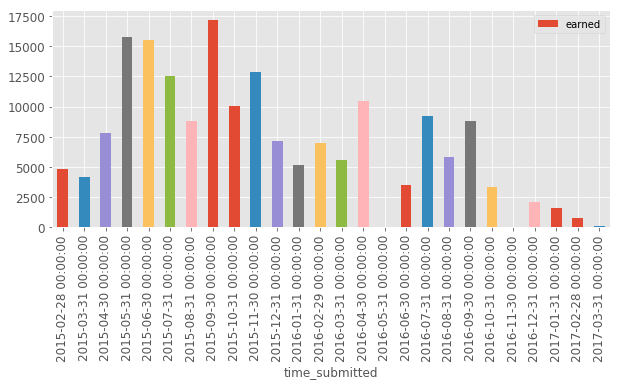

In [68]:
# 分析zhengnami13

query = {
    "query": {
        "match": {
            "_id": 7347639
        }
    }
}

res = es.search(index="userreview", body=query)

d = []
userreview = res['hits']['hits'][0]['_source']['userreview']

# 载入所有的项目信息到临时数组
for x in userreview:
    if x['sealed']:
        continue

    d.append((x['time_submitted'], x['currency']
              ['exchange_rate'] * x['paid_amount'], 1))

df = pd.DataFrame(d, columns=['time_submitted', 'earned', 'project_count'])

# 将time_submitted转换为datetime，以秒作为时间单位
df['time_submitted'] = pd.to_datetime(df['time_submitted'], unit='s')

# 将time_submitted设置为索引
df.set_index('time_submitted', inplace=True)

# 同时也保留时间
df['time'] = df.index

# 将时间按照一个月进行重采样，数据加起来
df = df.resample('1M').sum().fillna(0)

# 计算平均值
df['average'] = df['earned']/df['project_count']

df.plot.bar(y='earned', figsize=[10, 4])

df[df.index < END_DATE].to_json(
    "./web/data/zhengnami13_projects.json", orient='index', double_precision=2)

plt.show()

# 用户ZHENGNAMI13接单类型和客户分析

该用户主攻方向和描述一致，主要是涉及到移动领域的开发。具体来讲iOS的比Android开发更多，纯HTML5的开发也占有少量的比例。 该用户的客户主要是欧美和澳洲的客户，这些客户质量要求高、资金雄厚，
做好这些客户也可以给自己打下良好的口碑的基础。

In [69]:
query = {
    "query": {
        "constant_score": {
            "filter": {
                "terms": {
                    "user.public_name.keyword": ["zhengnami13"]
                }
            }
        }
    }
}

res = es.search(index="user", body=query)

d = []
for hit in res['hits']['hits']:
    user = hit['_source']['user']
    for job in user['reputation']['job_history']['job_counts']:
        d.append((user['public_name'], job['job']['category']
                  ['name'], job['job']['name'], job['count']))

df = pd.DataFrame(
    d, columns=['username', 'category', 'category_detail_name', 'count'])
df.set_index(['username', 'category', 'category_detail_name'])
df.to_json("./web/data/zhengnami13_category.json", orient='split')

display(df)

,username,category,category_detail_name,count
0,zhengnami13,Mobile Phones & Computing,Mobile Phone,151
1,zhengnami13,Mobile Phones & Computing,iPhone,135
2,zhengnami13,Mobile Phones & Computing,Android,100
3,zhengnami13,Mobile Phones & Computing,iPad,56
4,zhengnami13,"Websites, IT & Software",HTML5,36


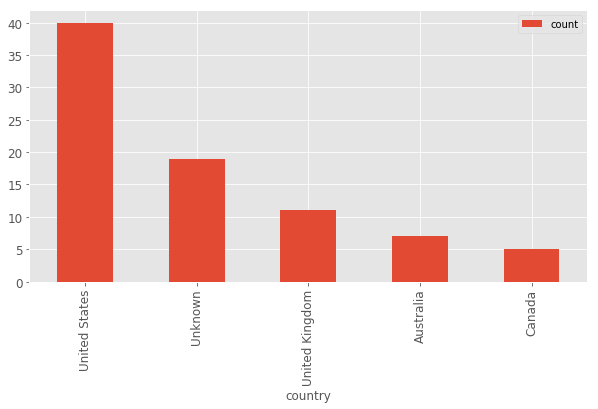

In [70]:
def get_user_country(user_id):
    query = {
        "query": {
            "match": {
                "_id": user_id
            }
        }
    }

    res = es.search(index="user", body=query)
    hits = res['hits']['hits']
    if len(hits) == 0:
        return "Unknown"

    user = hits[0]['_source']['user']
    return user['location']['country']['name']


clients = []
for x in userreview:
    clients.append(get_user_country(x['from_user_id']))

df = pd.DataFrame(clients, columns=["country"])
df['count'] = 1
df = df.groupby("country").count().sort_values("count", ascending=False)
df[0:5].plot(kind='bar')
df.to_json("./web/data/zhengnami13_customers.json")
plt.show()

# 雇员的接单量分析

在这个分析中，将会用到两层聚合。首先对雇主项目最终选择的投标人的国家进行聚合，然后在对雇主进行聚合，可以得到国家A的雇主对国家B的雇员的热图的分布情况。将此数据导出后在地图上进行可视化后可以看到价值输出的图，请见后文。

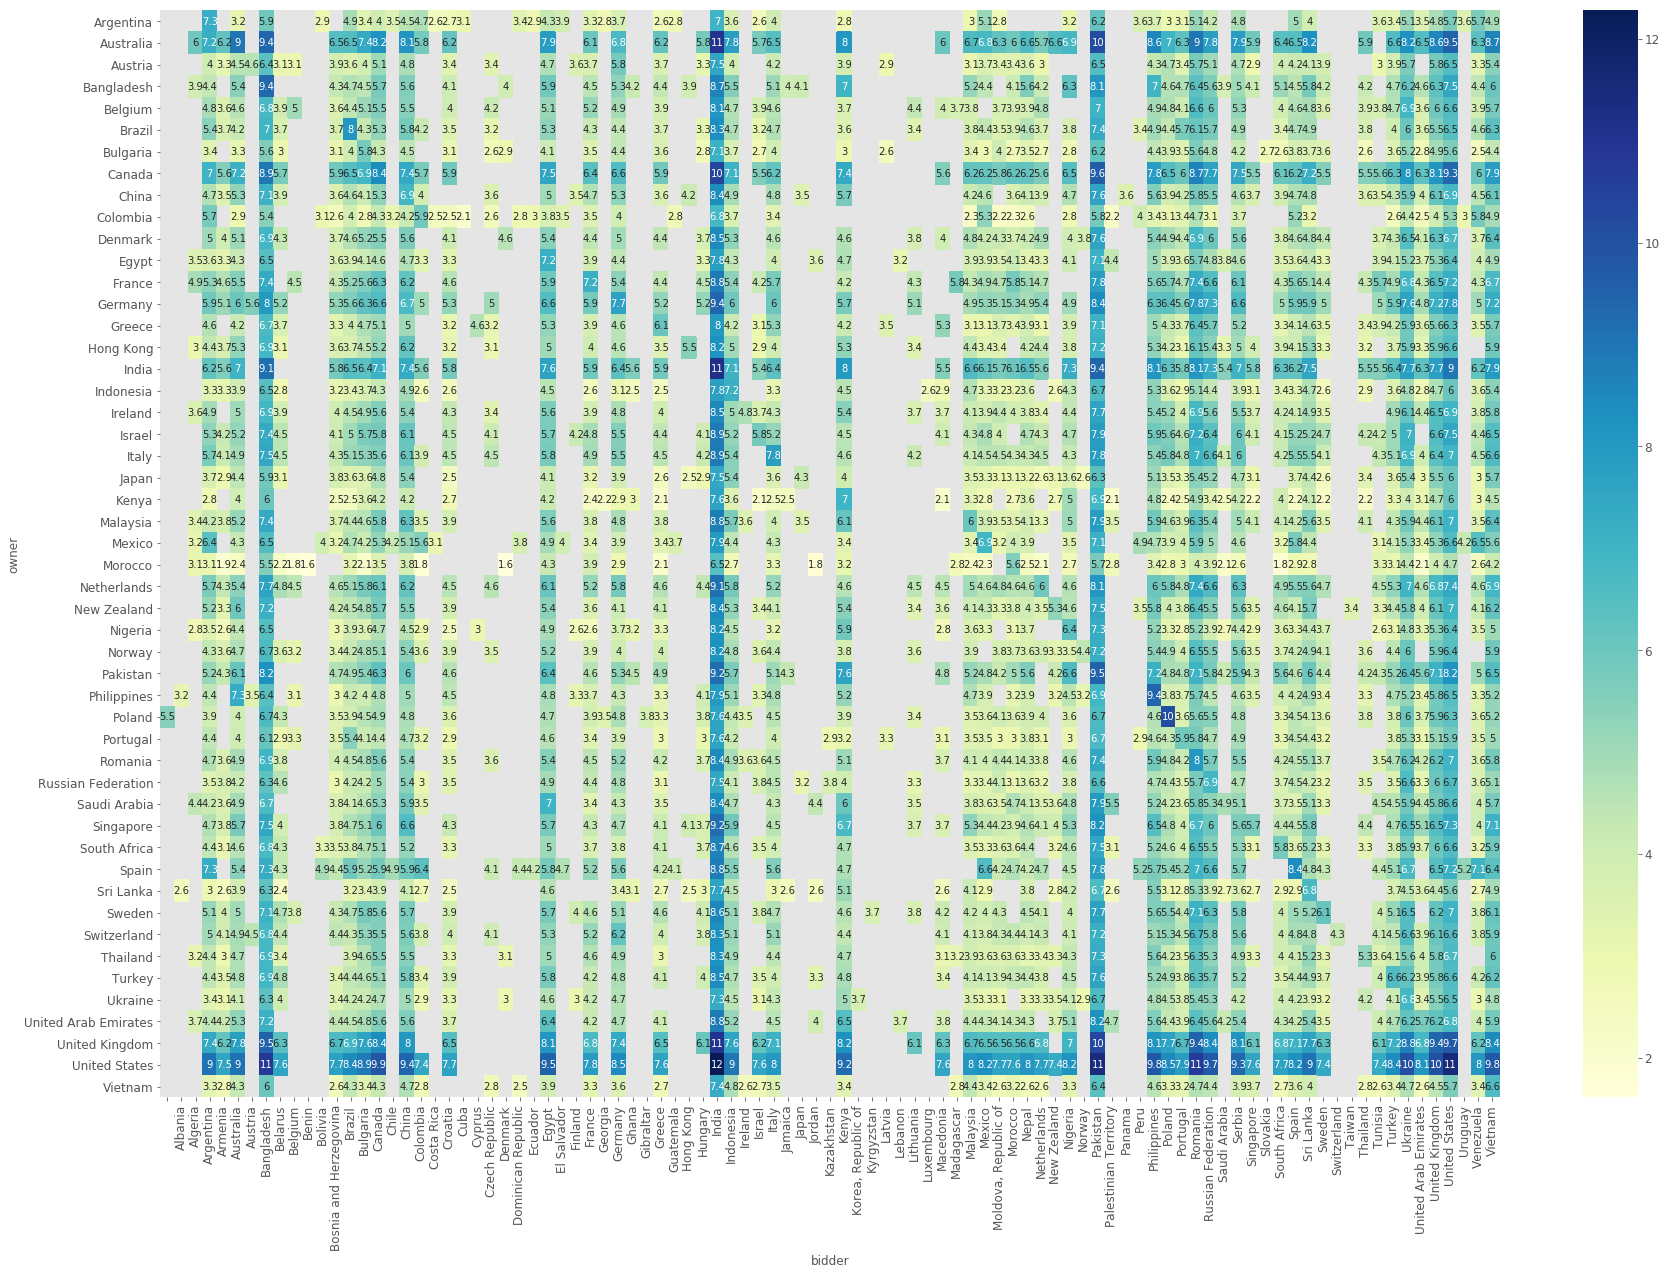

In [71]:
import seaborn as sns
import math

query = {
    "size": 0,
    "aggs": {
        "agg1": {
            "terms": {
                "field": "project.owner.location.country.name.keyword",
                "size": 50
            },
            "aggs": {
                "agg2": {
                    "terms": {
                        "field": "project.selected_bids.bidder.location.country.name.keyword",
                        "size": 50
                    }
                }
            }
        }
    }
}

res = es.search(index="project", body=query)
data = res['aggregations']['agg1']['buckets']

owners = {}
for d in data:
    bidders = {}
    for bid in d['agg2']['buckets']:
        bidders[bid['key']] = bid['doc_count']
    owners[d['key']] = bidders

# 将key-value形式的值转换为DataFrame
df = pd.DataFrame(pd.DataFrame().from_dict(owners, orient='index').stack(), columns=['count'])

# 将数值进行对数化更容易在数量级上进行比较
df['count_log'] = df['count'].apply(lambda x: math.log(x))
df.index.names = ['owner', 'bidder']
df['count'].to_json("./web/data/heatmap.json", orient='split')

# 目前DataFrame为multi-index，通过reset_index方法可以将multi-index转换成单一的index。
# pivot方法将DataFrame转换成二维表格，以owner作为行，bidder作为列，count_log作为值
# 如果需要直观的了解到DataFrame的转换过程，可以使用display命令将步骤打印出来，方便调试。注释掉下面三行即可看到整个过程。
# display(df)
# display(df.reset_index())
# display(df.reset_index().pivot("owner", "bidder", "count_log"))

df = df.reset_index().pivot("owner", "bidder", "count_log")
plt.figure(figsize=(30, 20))
sns.heatmap(df, cmap="YlGnBu", annot=True)
plt.show()